RNN test

In [2]:
# import all libraries for this project 
# main libraries 
import os 
import time 
import random 
import numpy as np 
import pandas as pd 

# visualization 
import matplotlib.pyplot as plt 
import seaborn as sns 

# PyTorch libraries 
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 

# metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# seed values 
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Plot style
plt.style.use("seaborn-v0_8")

Shape:  (851264, 7)
         date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtype

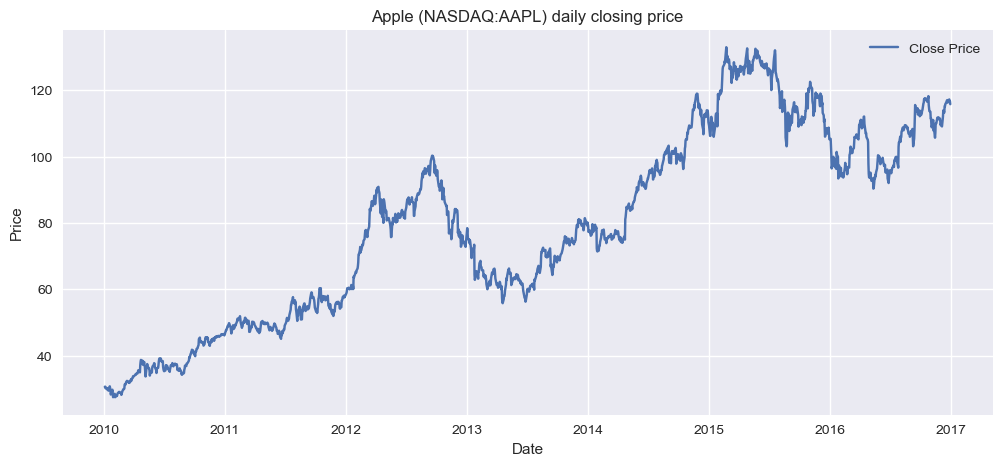

In [3]:
# Load data from disk

# File location
DATA_PATH = r"D:\Datasets\NYSEPrices\prices-split-adjusted.csv"

# Load Dataset 
df = pd.read_csv(DATA_PATH) 

# Basic inspection 
print("Shape: ", df.shape)
print(df.head())
print(df.info())

# Filter only for AAPL (apple stock)
df = df[df["symbol"] == "AAPL"].copy()

# Ensure sufficient data
assert df.shape[0] >= 1000, "Dataset has fewer than 1000 rows!"

# convert date column to datetime datatype 
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

print("AAPL Shape:", df.shape)

# Plotting the closing price 
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["close"], label="Close Price")
plt.title("Apple (NASDAQ:AAPL) daily closing price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [4]:
# check for missing values in series

if df["close"].isna().sum() == 0:
    print("All OK!, no missing target values")
else: 
    print("Null values present!")

# since this is =0, I have no missing values 


All OK!, no missing target values


In [5]:
# Additional metadata and other variables 
sequence_length = 30 # lookback window 
prediction_horizon = 5 # forecast steps 
target_column = "close"

# Extract target series 
# This would be a text value in the dataframe, so I need to change the data
series = df[target_column].values.astype(np.float32)

# split into train/validation split 

split_idx = int(len(series)*0.9)
print(f"The training series ends at {split_idx}")

train_series = series[:split_idx]
val_series = series[split_idx:]

print("Train length: ", len(train_series))
print("Validation length: ", len(val_series))



The training series ends at 1585
Train length:  1585
Validation length:  177


In [6]:
# use standardization instead of normalization

# statistics of targetvalue 
train_mean = train_series.mean()
train_std = train_series.std()

# Standardize 
train_series_scaled = (train_series - train_mean) / train_std 
val_series_scaled = (val_series - train_mean) / train_std

In [7]:
# sliding window creation 
def create_sequences(data, seq_length, horizon):
    X, y = [], []

    for i in range(len(data) - seq_length - horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + horizon])
    return np.array(X), np.array(y)

# Create the sequences 
X_train, y_train = create_sequences( 
    train_series_scaled, sequence_length, prediction_horizon
)

X_val, y_val = create_sequences( 
    val_series_scaled, sequence_length, prediction_horizon
)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)


X_train shape:  (1551, 30)
y_train shape:  (1551, 5)
X_val shape:  (143, 30)
y_val shape:  (143, 5)


In [8]:
# define functions to calculate the metrics 
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/ y_true))*100

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

Step 2: Setup and configure RNN LSTM

In [9]:
# convert dataframe to pytorch tensor 
# Add feature dimension 

X_train_t = torch.tensor(X_train).unsqueeze(-1)
y_train_t = torch.tensor(y_train)

X_val_t = torch.tensor(X_val).unsqueeze(-1)
y_val_t = torch.tensor(y_val)

print("X_train tensor shape:", X_train_t.shape)
print("Y_train tensor shape:", y_train_t.shape)

X_train tensor shape: torch.Size([1551, 30, 1])
Y_train tensor shape: torch.Size([1551, 5])


In [10]:
# Create a dataset and dataloader 

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32 

train_dataset = TimeSeriesDataset(X_train_t, y_train_t)
val_dataset = TimeSeriesDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class RNNModel(nn.Module):
    def __init__(self, model_type, input_size, hidden_units, n_layers, output_size):
        super().__init__()

        if model_type == "LSTM":
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_units,
                num_layers=n_layers,
                batch_first=True
            )
        elif model_type == "GRU":
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_units,
                num_layers=n_layers,
                batch_first=True
            )
        else:
            raise ValueError("model_type must be 'LSTM' or 'GRU'")

        self.fc = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden)


def build_rnn_model(model_type, input_shape, hidden_units, n_layers, output_size):
    _, n_features = input_shape
    return RNNModel(
        model_type=model_type,
        input_size=n_features,
        hidden_units=hidden_units,
        n_layers=n_layers,
        output_size=output_size
    )


In [12]:
# Initialize model, loss, optimizer
# Optimizer: Adam
# Loss function: MSE 

rnn_model = build_rnn_model( 
    model_type = "LSTM",
    input_shape=(sequence_length, 1),
    hidden_units=64,
    n_layers=2,
    output_size=prediction_horizon
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

#Parameter count 
rnn_param_count = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
print("RNN Parameters:", rnn_param_count)

RNN Parameters: 50757


In [13]:
# Training loop and final loss 
epochs = 20
rnn_losses = []

rnn_start_time = time.time()

for epoch in range(epochs):
    rnn_model.train()
    epoch_loss = 0.0

    for X_batch, y_batch, in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    rnn_losses.append(avg_loss)

    if epoch == 0:
        rnn_initial_loss = avg_loss 

    print(f"Epoch [{epoch+1}/{epochs}], Loss{avg_loss:.6f}")

rnn_final_loss = rnn_losses[-1]
rnn_training_time = time.time() - rnn_start_time


Epoch [1/20], Loss0.891686
Epoch [2/20], Loss0.487945
Epoch [3/20], Loss0.313360
Epoch [4/20], Loss0.246011
Epoch [5/20], Loss0.134550
Epoch [6/20], Loss0.103274
Epoch [7/20], Loss0.070218
Epoch [8/20], Loss0.042702
Epoch [9/20], Loss0.028674
Epoch [10/20], Loss0.020909
Epoch [11/20], Loss0.018336
Epoch [12/20], Loss0.016194
Epoch [13/20], Loss0.015159
Epoch [14/20], Loss0.015019
Epoch [15/20], Loss0.015150
Epoch [16/20], Loss0.015303
Epoch [17/20], Loss0.015421
Epoch [18/20], Loss0.015484
Epoch [19/20], Loss0.015491
Epoch [20/20], Loss0.015442


In [14]:
rnn_model.eval()

with torch.no_grad():
    y_val_preds = []
    y_val_true = []

    for X_batch, y_batch in val_loader:
        preds = rnn_model(X_batch)
        y_val_preds.append(preds.numpy())
        y_val_true.append(y_batch.numpy())

y_val_preds = np.vstack(y_val_preds)
y_val_true = np.vstack(y_val_true)

# Metrics
rnn_mae = calculate_mae(y_val_true, y_val_preds)
rnn_rmse = calculate_rmse(y_val_true, y_val_preds)
rnn_mape = calculate_mape(y_val_true, y_val_preds)
rnn_r2 = calculate_r2(y_val_true, y_val_preds)

print("RNN MAE:", rnn_mae)
print("RNN RMSE:", rnn_rmse)
print("RNN MAPE:", rnn_mape)
print("RNN R²:", rnn_r2)

RNN MAE: 0.10474409908056259
RNN RMSE: 0.12613754927505985
RNN MAPE: 10.680656
RNN R²: 0.7516037225723267


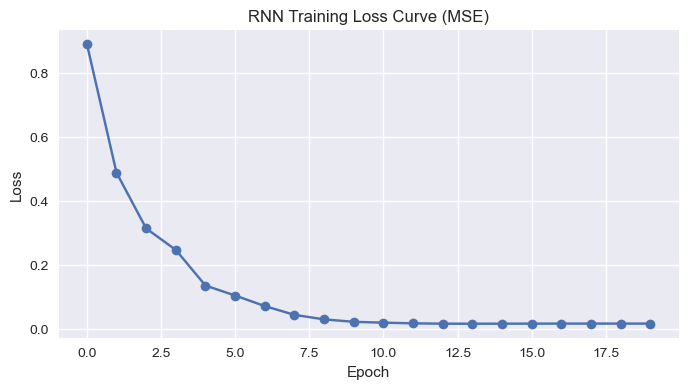

In [15]:
# Visualize the results of LSTM results 
plt.figure(figsize=(8, 4))
plt.plot(rnn_losses, marker='o')
plt.title("RNN Training Loss Curve (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


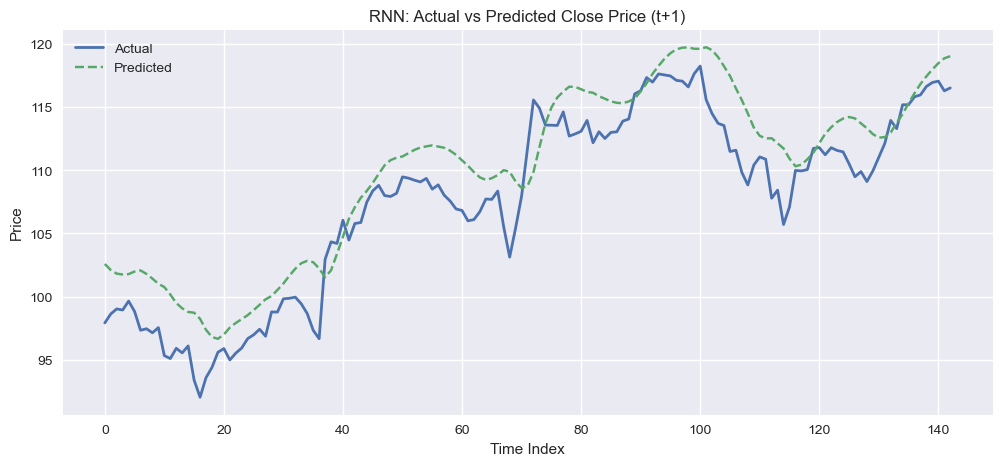

In [16]:
# invert the standardization so that we can see final prices 

y_val_preds_inv = y_val_preds * train_std + train_mean
y_val_true_inv = y_val_true * train_std + train_mean

plt.figure(figsize=(12, 5))

plt.plot(
    y_val_true_inv[:, 0],
    label="Actual",
    linewidth=2
)

plt.plot(
    y_val_preds_inv[:, 0],
    label="Predicted",
    linestyle="--"
)

plt.title("RNN: Actual vs Predicted Close Price (t+1)")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.show()

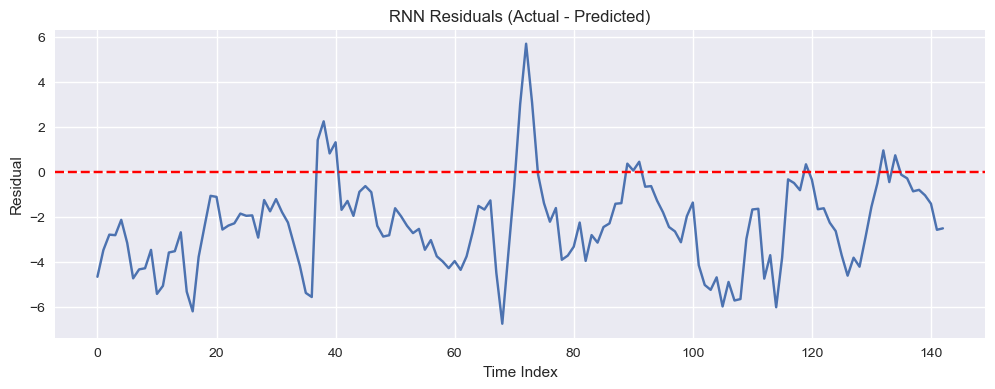

In [17]:
# residuals analysis 

residuals = y_val_true_inv[:, 0] - y_val_preds_inv[:, 0]

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("RNN Residuals (Actual - Predicted)")
plt.xlabel("Time Index")
plt.ylabel("Residual")
plt.show()

In [31]:
# Implementation of Transformer Encoder for Time series 

# Implementation of positional encoding 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp( 
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer("pe",pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

In [32]:
class TransformerModel(nn.Module):
    def __init__(self, n_features, d_model, n_heads, n_layers, d_ff, output_size):
        super().__init__()

        self.input_projection = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers
        )

        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global Average Pooling
        return self.fc(x)


In [33]:
# Initialize Transformer, loss, and optimizer

transformer_model = TransformerModel(
    n_features=1,
    d_model=64,
    n_heads=4,
    n_layers=2,
    d_ff=128,
    output_size=prediction_horizon
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

# Parameter count
transformer_param_count = sum(
    p.numel() for p in transformer_model.parameters() if p.requires_grad
)

print("Transformer Parameters:", transformer_param_count)


Transformer Parameters: 67397


In [34]:
epochs = 20
transformer_losses = []

transformer_start_time = time.time()

for epoch in range(epochs):
    transformer_model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = transformer_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    transformer_losses.append(avg_loss)

    if epoch == 0:
        transformer_initial_loss = avg_loss

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

transformer_final_loss = transformer_losses[-1]
transformer_training_time = time.time() - transformer_start_time


Epoch [1/20], Loss: 0.345230
Epoch [2/20], Loss: 0.305289
Epoch [3/20], Loss: 0.258152
Epoch [4/20], Loss: 0.364726
Epoch [5/20], Loss: 0.282663
Epoch [6/20], Loss: 0.212020
Epoch [7/20], Loss: 0.117936
Epoch [8/20], Loss: 0.081899
Epoch [9/20], Loss: 0.064064
Epoch [10/20], Loss: 0.045374
Epoch [11/20], Loss: 0.051731
Epoch [12/20], Loss: 0.047466
Epoch [13/20], Loss: 0.042536
Epoch [14/20], Loss: 0.040919
Epoch [15/20], Loss: 0.033880
Epoch [16/20], Loss: 0.021601
Epoch [17/20], Loss: 0.019905
Epoch [18/20], Loss: 0.016087
Epoch [19/20], Loss: 0.040190
Epoch [20/20], Loss: 0.042901


In [37]:
# Build transformer validation data

transformer_model.eval()

with torch.no_grad():
    y_val_preds_tf = []
    y_val_true_tf = []

    for X_batch, y_batch in val_loader:
        preds = transformer_model(X_batch)
        y_val_preds_tf.append(preds.numpy())
        y_val_true_tf.append(y_batch.numpy())

y_val_preds_tf = np.vstack(y_val_preds_tf)
y_val_true_tf = np.vstack(y_val_true_tf)

# Metrics
transformer_mae = calculate_mae(y_val_true_tf, y_val_preds_tf)
transformer_rmse = calculate_rmse(y_val_true_tf, y_val_preds_tf)
transformer_mape = calculate_mape(y_val_true_tf, y_val_preds_tf)
transformer_r2 = calculate_r2(y_val_true_tf, y_val_preds_tf)

print("Transformer MAE:", transformer_mae)
print("Transformer RMSE:", transformer_rmse)
print("Transformer MAPE:", transformer_mape)
print("Transformer R²:", transformer_r2)

Transformer MAE: 0.3506198525428772
Transformer RMSE: 0.3761590490006494
Transformer MAPE: 35.97339
Transformer R²: -1.2087663412094116


In [38]:
# Invert transformer prediction from standard values to actual values 
y_val_preds_tf_inv = y_val_preds_tf * train_std + train_mean
y_val_true_tf_inv = y_val_true_tf * train_std + train_mean


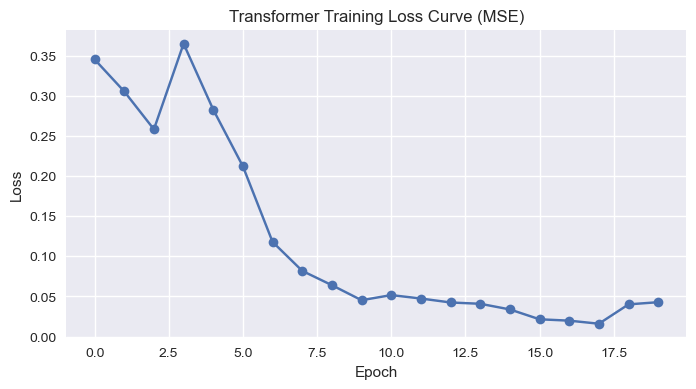

In [39]:
# Plot the transformer training loss 

plt.figure(figsize=(8, 4))
plt.plot(transformer_losses, marker='o')
plt.title("Transformer Training Loss Curve (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

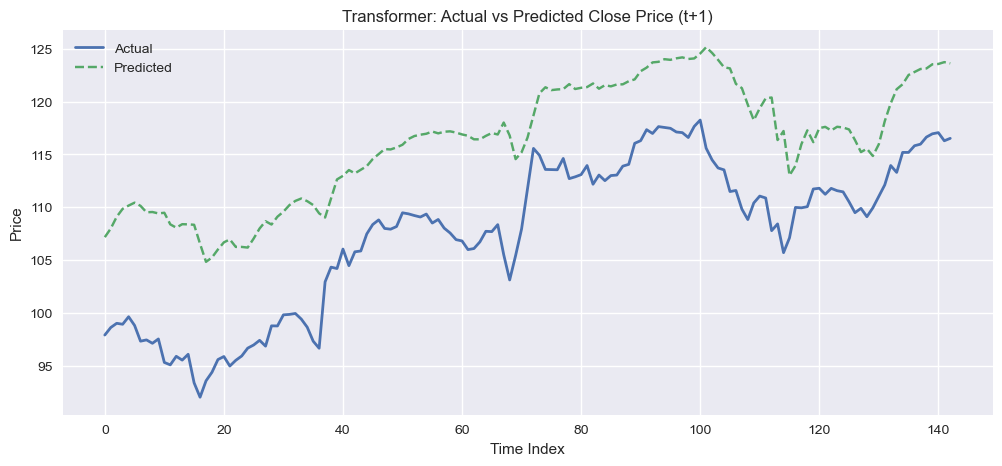

In [42]:
# Plot the actual vs predicted prices for transformer 

plt.figure(figsize=(12, 5))

plt.plot(
    y_val_true_tf_inv[:, 0],
    label="Actual",
    linewidth=2
)

plt.plot(
    y_val_preds_tf_inv[:, 0],
    label="Predicted",
    linestyle="--"
)

plt.title("Transformer: Actual vs Predicted Close Price (t+1)")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.show()

In [43]:
# crete a comparision dataframe 

comparison_df = pd.DataFrame({
    'Metric': [
        'MAE',
        'RMSE',
        'MAPE (%)',
        'R² Score',
        'Training Time (s)',
        'Parameters'
    ],
    'RNN (LSTM)': [
        rnn_mae,
        rnn_rmse,
        rnn_mape,
        rnn_r2,
        rnn_training_time,
        rnn_param_count
    ],
    'Transformer': [
        transformer_mae,
        transformer_rmse,
        transformer_mape,
        transformer_r2,
        transformer_training_time,
        transformer_param_count
    ]
})

comparison_df


,Metric,RNN (LSTM),Transformer
0,MAE,0.104744,0.350620
1,RMSE,0.126138,0.376159
2,MAPE (%),10.680656,35.973389
3,R² Score,0.751604,-1.208766
4,Training Time (s),4.143193,23.514297
5,Parameters,50757.000000,67397.000000


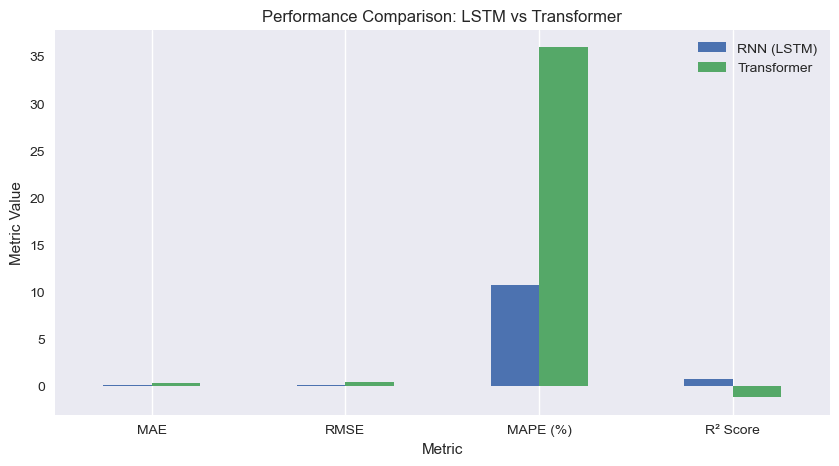

In [44]:
# bar plot comparision of metrics 

metrics_only = comparison_df.iloc[:4].set_index("Metric")

metrics_only.plot(
    kind="bar",
    figsize=(10, 5)
)

plt.title("Performance Comparison: LSTM vs Transformer")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


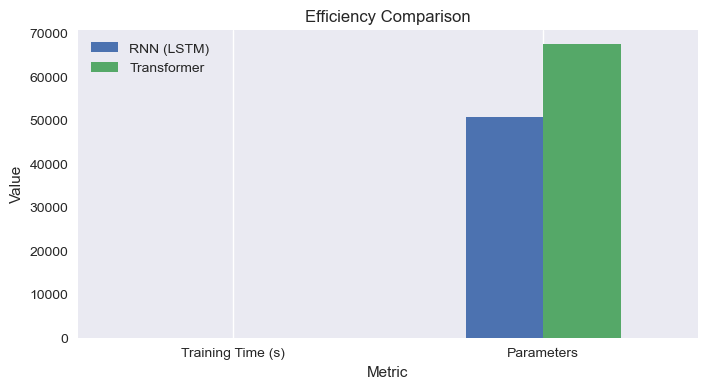

In [45]:
# training time comparision and parameter estimation 

efficiency_df = comparison_df.iloc[4:].set_index("Metric")

efficiency_df.plot(
    kind="bar",
    figsize=(8, 4)
)

plt.title("Efficiency Comparison")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


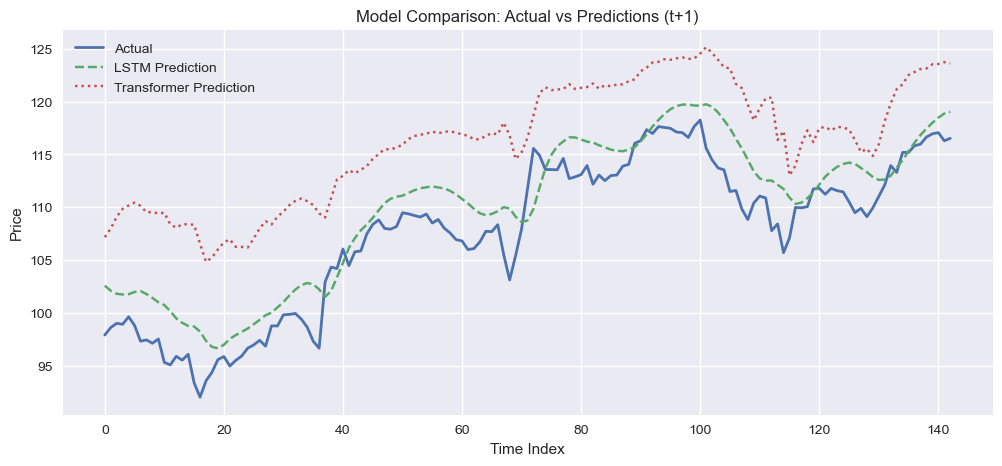

In [46]:
# t+1 forecast 

plt.figure(figsize=(12, 5))

plt.plot(
    y_val_true_inv[:, 0],
    label="Actual",
    linewidth=2
)

plt.plot(
    y_val_preds_inv[:, 0],
    label="LSTM Prediction",
    linestyle="--"
)

plt.plot(
    y_val_preds_tf_inv[:, 0],
    label="Transformer Prediction",
    linestyle=":"
)

plt.title("Model Comparison: Actual vs Predictions (t+1)")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.show()


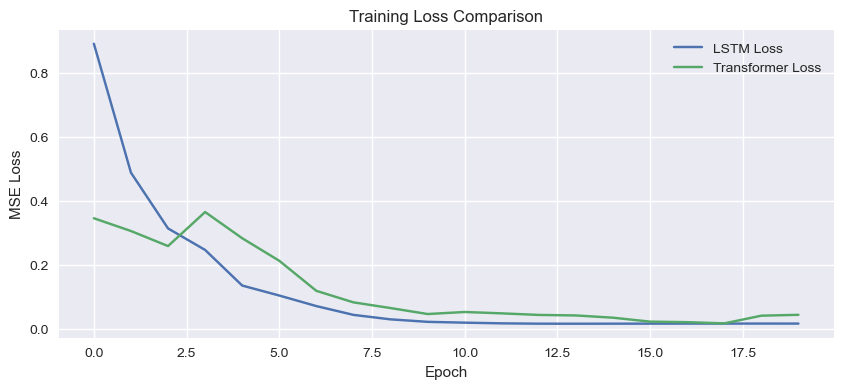

In [47]:
# training loss curves comparision 

plt.figure(figsize=(10, 4))

plt.plot(rnn_losses, label="LSTM Loss")
plt.plot(transformer_losses, label="Transformer Loss")

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()
